
# Montar las carpetas de google drive.
# Create environment in Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Move to google drive environment
%cd /content/drive/MyDrive/TFM Comparativa Soluciones

/content/drive/MyDrive/TFM Comparativa Soluciones


# Funciones para ejecutar el código

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

from PIL import Image
from IPython.display import FileLink 

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224

    if model_name == "resnet50":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [6]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???

        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="melanoma_hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array            
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [9]:
image_path_dict = {'train': "train",
                  'val': "train" ,
                  'test': "train"}

dataframes_path = 'melanoma_without_duplicates_separated/'

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [11]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

 
def get_loss(num_classes,device):
    # Create an instance of the loss function
    # We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    #pos_weight = torch.tensor(np.ones(num_classes))
    #pos_weight = pos_weight.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    #criterion = FocalLoss()
    return criterion

In [12]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path=dataframes_path + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [13]:
val_df = pd.read_csv(dataframes_path + "val.csv")
val_real = []
for i in range(val_df.shape[0]):
    val_real.append(val_df['target'].iloc[i])

In [14]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    import time
    start_time = time.time()
    
    #take out if just starting to train
    #checkpoint = torch.load("../input/shuffle-meta-conf-matrix/resnet_weights_12.pt")
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']

    train_losses = []
    test_losses = []
    train_auc=[]
    val_auc=[]
    train_pred = []
    train_real = []
    val_pred = []
    val_real = []
    for epoch in range(num_epochs):

        train_preds=[]
        train_targets=[]
        auc_train=[]
        loss_epoch_train=[]
        loss_epoch_test=[]
        # Run the training batches
        for inputs, features, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, features)
            outputs = torch.squeeze(outputs)
            #outputs = torch.as_tensor(outputs.tolist())
            preds = (outputs > 0).type(torch.float64)
            train_real.extend(labels.tolist())
            train_pred.extend(preds.tolist())
            
            labels = torch.squeeze(labels)
            loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
            loss_epoch_train.append(loss.item())
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        auc_train=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        #auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
        
        train_losses.append(np.mean(loss_epoch_train))
        train_auc.append(auc_train)
        
        print(f'Epoch: {epoch:2} Train Loss: {np.mean(loss_epoch_train):10.8f} AUC: {auc_train:10.8f} ')
        df_confusion = confusion_matrix(train_real, train_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        # Run the testing batches
        with torch.no_grad():
            for inputs, features, labels in tqdm(dataloaders['val']):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, features)
                #print('outputs1 ' + str(outputs))

                outputs = torch.squeeze(outputs)
                #print('outputs2 ' + str(outputs))
                preds = (outputs > 0).type(torch.float64)
                #print('labels ' + (str(labels)))
                #print('pred ' + str(preds))
                val_real.extend(labels.tolist())
                val_pred.extend(preds.tolist())
                
                #outputs = torch.as_tensor(outputs.tolist())
                #print('new outs', outputs)
                labels = torch.squeeze(labels)
                loss = criterion(torch.sigmoid(outputs.type(torch.FloatTensor)), labels.type(torch.FloatTensor))
                loss_epoch_test.append(loss.item())
                                          
        auc_val=roc_auc_score(labels.detach().cpu().numpy(),torch.sigmoid(outputs).detach().cpu().numpy())
        
        test_losses.append(np.mean(loss_epoch_test))
        val_auc.append(auc_val)
        
        print(f'Epoch: {epoch} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
        df_confusion = confusion_matrix(val_real, val_pred)
        df_conf_norm = df_confusion / df_confusion.sum(axis=1, keepdims = True)
        print(df_conf_norm)
        
        if epoch % 5==0:
        #if epoch % 5==0:
            model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
            torch.save(model_file, dataframes_path + "Pesos resnet50/{}_weights_{}.pt".format(model_name, epoch))
        #epoch if just started training
        #epoch + epoch_before + 1 afterwards
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
    return train_auc, val_auc, train_losses,test_losses

In [15]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet50'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 64

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 200

# Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [17]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

# Train the model!
train_auc, val_auc,train_losses,test_losses  = train_model(model=model,
            dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
            scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.conv1.weight
	 cnn.bn1.weight
	 cnn.bn1.bias
	 cnn.layer1.0.conv1.weight
	 cnn.layer1.0.bn1.weight
	 cnn.layer1.0.bn1.bias
	 cnn.layer1.0.conv2.weight
	 cnn.layer1.0.bn2.weight
	 cnn.layer1.0.bn2.bias
	 cnn.layer1.0.conv3.weight
	 cnn.layer1.0.bn3.weight
	 cnn.layer1.0.bn3.bias
	 cnn.layer1.0.downsample.0.weight
	 cnn.layer1.0.downsample.1.weight
	 cnn.layer1.0.downsample.1.bias
	 cnn.layer1.1.conv1.weight
	 cnn.layer1.1.bn1.weight
	 cnn.layer1.1.bn1.bias
	 cnn.layer1.1.conv2.weight
	 cnn.layer1.1.bn2.weight
	 cnn.layer1.1.bn2.bias
	 cnn.layer1.1.conv3.weight
	 cnn.layer1.1.bn3.weight
	 cnn.layer1.1.bn3.bias
	 cnn.layer1.2.conv1.weight
	 cnn.layer1.2.bn1.weight
	 cnn.layer1.2.bn1.bias
	 cnn.layer1.2.conv2.weight
	 cnn.layer1.2.bn2.weight
	 cnn.layer1.2.bn2.bias
	 cnn.layer1.2.conv3.weight
	 cnn.layer1.2.bn3.weight
	 cnn.layer1.2.bn3.bias
	 cnn.layer2.0.conv1.weight
	 cnn.layer2.0.bn1.weight
	 cnn.layer2.0.bn1.bias
	 cnn.layer2.0.conv2.weight
	 cnn.layer2.0.bn2.we

100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch:  0 Train Loss: 0.72510876 AUC: 0.68353175 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Epoch: 0 Val Loss: 0.72126422 AUC: 0.69639469 
[[1. 0.]
 [1. 0.]]


100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch:  1 Train Loss: 0.70367191 AUC: 0.85141740 
[[1. 0.]
 [1. 0.]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 1 Val Loss: 0.69415713 AUC: 0.55407970 
[[0.99774775 0.00225225]
 [0.99285714 0.00714286]]


100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch:  2 Train Loss: 0.66799842 AUC: 0.83152709 
[[0.98759865 0.01240135]
 [0.95204122 0.04795878]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 2 Val Loss: 0.68399626 AUC: 0.58254269 
[[0.97297297 0.02702703]
 [0.92857143 0.07142857]]


100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


Epoch:  3 Train Loss: 0.64203814 AUC: 0.84901961 
[[0.97266065 0.02733935]
 [0.86058264 0.13941736]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 3 Val Loss: 0.67747132 AUC: 0.64705882 
[[0.94144144 0.05855856]
 [0.85952381 0.14047619]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch:  4 Train Loss: 0.62460526 AUC: 0.82638889 
[[0.95264938 0.04735062]
 [0.76527943 0.23472057]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 4 Val Loss: 0.67412211 AUC: 0.63946869 
[[0.90720721 0.09279279]
 [0.79238095 0.20761905]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch:  5 Train Loss: 0.62161367 AUC: 0.88388388 
[[0.93855693 0.06144307]
 [0.70253666 0.29746334]]


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Epoch: 5 Val Loss: 0.66620320 AUC: 0.68690702 
[[0.89489489 0.10510511]
 [0.75714286 0.24285714]]


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch:  6 Train Loss: 0.61350931 AUC: 0.89753695 
[[0.92945724 0.07054276]
 [0.65330389 0.34669611]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 6 Val Loss: 0.67722897 AUC: 0.62618596 
[[0.87387387 0.12612613]
 [0.72108844 0.27891156]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch:  7 Train Loss: 0.60728082 AUC: 0.95208333 
[[0.92277339 0.07722661]
 [0.61102854 0.38897146]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 7 Val Loss: 0.66050710 AUC: 0.78747628 
[[0.8704955  0.1295045 ]
 [0.70119048 0.29880952]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch:  8 Train Loss: 0.60609662 AUC: 0.95138889 
[[0.92095703 0.07904297]
 [0.58409301 0.41590699]]


100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 8 Val Loss: 0.66765387 AUC: 0.74952562 
[[0.85985986 0.14014014]
 [0.67936508 0.32063492]]


100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Epoch:  9 Train Loss: 0.60553741 AUC: 0.91202346 
[[0.91465614 0.08534386]
 [0.5548157  0.4451843 ]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 9 Val Loss: 0.66875155 AUC: 0.70967742 
[[0.85405405 0.14594595]
 [0.66619048 0.33380952]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 10 Train Loss: 0.60812154 AUC: 0.82697947 
[[0.91093574 0.08906426]
 [0.53432061 0.46567939]]


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch: 10 Val Loss: 0.66363373 AUC: 0.69449715 
[[0.84807535 0.15192465]
 [0.65021645 0.34978355]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 11 Train Loss: 0.60029218 AUC: 0.95405670 
[[0.9091507  0.0908493 ]
 [0.51525961 0.48474039]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 11 Val Loss: 0.66777591 AUC: 0.71537002 
[[0.84421922 0.15578078]
 [0.64246032 0.35753968]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 12 Train Loss: 0.59811514 AUC: 0.90376984 
[[0.9085075 0.0914925]
 [0.4995884 0.5004116]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 12 Val Loss: 0.66947717 AUC: 0.70208729 
[[0.83714484 0.16285516]
 [0.62783883 0.37216117]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 13 Train Loss: 0.59912765 AUC: 0.90615836 
[[0.90755355 0.09244645]
 [0.48590114 0.51409886]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 13 Val Loss: 0.66742256 AUC: 0.73529412 
[[0.83365508 0.16634492]
 [0.61870748 0.38129252]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 14 Train Loss: 0.59693669 AUC: 0.86176471 
[[0.906351   0.093649  ]
 [0.47380103 0.52619897]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 14 Val Loss: 0.67468681 AUC: 0.67172676 
[[0.82792793 0.17207207]
 [0.60857143 0.39142857]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 15 Train Loss: 0.59780063 AUC: 0.88627451 
[[0.90607384 0.09392616]
 [0.46380797 0.53619203]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 15 Val Loss: 0.67175981 AUC: 0.70967742 
[[0.82685811 0.17314189]
 [0.60625    0.39375   ]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 16 Train Loss: 0.59334724 AUC: 0.91694352 
[[0.90609457 0.09390543]
 [0.45345177 0.54654823]]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch: 16 Val Loss: 0.67728129 AUC: 0.70588235 
[[0.82299947 0.17700053]
 [0.60196078 0.39803922]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 17 Train Loss: 0.59435247 AUC: 0.91491491 
[[0.90548666 0.09451334]
 [0.44424627 0.55575373]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 17 Val Loss: 0.65820670 AUC: 0.75996205 
[[0.81931932 0.18068068]
 [0.59047619 0.40952381]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 18 Train Loss: 0.59500478 AUC: 0.90090090 
[[0.90529876 0.09470124]
 [0.43669817 0.56330183]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 18 Val Loss: 0.67006189 AUC: 0.76470588 
[[0.81721195 0.18278805]
 [0.58621554 0.41378446]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 19 Train Loss: 0.59099561 AUC: 0.85515873 
[[0.90507328 0.09492672]
 [0.42901308 0.57098692]]


100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 19 Val Loss: 0.66683339 AUC: 0.73149905 
[[0.81554054 0.18445946]
 [0.58047619 0.41952381]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 20 Train Loss: 0.58764268 AUC: 0.88333333 
[[0.90486928 0.09513072]
 [0.42092747 0.57907253]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 20 Val Loss: 0.68034206 AUC: 0.69449715 
[[0.81274131 0.18725869]
 [0.57891156 0.42108844]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 21 Train Loss: 0.59036500 AUC: 0.91984360 
[[0.90463257 0.09536743]
 [0.41449573 0.58550427]]


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch: 21 Val Loss: 0.66963406 AUC: 0.75521822 
[[0.80835381 0.19164619]
 [0.57012987 0.42987013]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 22 Train Loss: 0.59126322 AUC: 0.97931034 
[[0.90500466 0.09499534]
 [0.40934705 0.59065295]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 22 Val Loss: 0.67263696 AUC: 0.70208729 
[[0.80552291 0.19447709]
 [0.56542443 0.43457557]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 23 Train Loss: 0.58885413 AUC: 0.96453202 
[[0.90496994 0.09503006]
 [0.40388426 0.59611574]]


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch: 23 Val Loss: 0.68208921 AUC: 0.73529412 
[[0.80105105 0.19894895]
 [0.56011905 0.43988095]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 24 Train Loss: 0.59049126 AUC: 0.95467980 
[[0.90444194 0.09555806]
 [0.398478   0.601522  ]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 24 Val Loss: 0.66594893 AUC: 0.75616698 
[[0.80018018 0.19981982]
 [0.55695238 0.44304762]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 25 Train Loss: 0.58941958 AUC: 0.85156250 
[[0.90430145 0.09569855]
 [0.39344187 0.60655813]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 25 Val Loss: 0.66281067 AUC: 0.76755218 
[[0.79885655 0.20114345]
 [0.55201465 0.44798535]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 26 Train Loss: 0.58677952 AUC: 0.91625616 
[[0.90450541 0.09549459]
 [0.38886687 0.61113313]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 26 Val Loss: 0.67105493 AUC: 0.71821632 
[[0.7967968  0.2032032 ]
 [0.54832451 0.45167549]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 27 Train Loss: 0.58851716 AUC: 0.89247312 
[[0.90465453 0.09534547]
 [0.38495838 0.61504162]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 27 Val Loss: 0.67100755 AUC: 0.73908918 
[[0.7953668  0.2046332 ]
 [0.54540816 0.45459184]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 28 Train Loss: 0.58905488 AUC: 0.89087302 
[[0.90405474 0.09594526]
 [0.38013039 0.61986961]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 28 Val Loss: 0.67203766 AUC: 0.78083491 
[[0.79403541 0.20596459]
 [0.54367816 0.45632184]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 29 Train Loss: 0.58975317 AUC: 0.92261905 
[[0.90420894 0.09579106]
 [0.37693222 0.62306778]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 29 Val Loss: 0.66941461 AUC: 0.72770398 
[[0.79354354 0.20645646]
 [0.54238095 0.45761905]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 30 Train Loss: 0.58716236 AUC: 0.88765182 
[[0.90475325 0.09524675]
 [0.37405546 0.62594454]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 30 Val Loss: 0.66597134 AUC: 0.70683112 
[[0.79264749 0.20735251]
 [0.53947773 0.46052227]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 31 Train Loss: 0.58293861 AUC: 0.81274510 
[[0.90543968 0.09456032]
 [0.37094976 0.62905024]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 31 Val Loss: 0.67168855 AUC: 0.72201139 
[[0.79082207 0.20917793]
 [0.53630952 0.46369048]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 32 Train Loss: 0.59019949 AUC: 0.87402344 
[[0.90550374 0.09449626]
 [0.36832054 0.63167946]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 32 Val Loss: 0.66845575 AUC: 0.72770398 
[[0.78978979 0.21021021]
 [0.53391053 0.46608947]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 33 Train Loss: 0.58798352 AUC: 0.97519841 
[[0.90602825 0.09397175]
 [0.36630062 0.63369938]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 33 Val Loss: 0.65809126 AUC: 0.74193548 
[[0.78974563 0.21025437]
 [0.53179272 0.46820728]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 34 Train Loss: 0.58322578 AUC: 0.81477833 
[[0.90642616 0.09357384]
 [0.36337693 0.63662307]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 34 Val Loss: 0.66749798 AUC: 0.79411765 
[[0.78970399 0.21029601]
 [0.53183673 0.46816327]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 35 Train Loss: 0.58567501 AUC: 0.92492492 
[[0.9070838  0.0929162 ]
 [0.36157352 0.63842648]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 35 Val Loss: 0.68701883 AUC: 0.69544592 
[[0.78728729 0.21271271]
 [0.52962963 0.47037037]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 36 Train Loss: 0.58729924 AUC: 0.90147059 
[[0.90767543 0.09232457]
 [0.35996401 0.64003599]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 36 Val Loss: 0.67161999 AUC: 0.72675522 
[[0.78694911 0.21305089]
 [0.52882883 0.47117117]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 37 Train Loss: 0.58438158 AUC: 0.88856305 
[[0.90847327 0.09152673]
 [0.35831404 0.64168596]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 37 Val Loss: 0.66917540 AUC: 0.70398482 
[[0.78686581 0.21313419]
 [0.52781955 0.47218045]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 38 Train Loss: 0.58460129 AUC: 0.90909091 
[[0.90894112 0.09105888]
 [0.35647428 0.64352572]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 38 Val Loss: 0.67286185 AUC: 0.70967742 
[[0.78632479 0.21367521]
 [0.52686203 0.47313797]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 39 Train Loss: 0.58350036 AUC: 0.96596597 
[[0.90918828 0.09081172]
 [0.35416171 0.64583829]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 39 Val Loss: 0.68662110 AUC: 0.67552182 
[[0.78547297 0.21452703]
 [0.5277381  0.4722619 ]]


100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Epoch: 40 Train Loss: 0.58373500 AUC: 0.89777328 
[[0.90975335 0.09024665]
 [0.35280299 0.64719701]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 40 Val Loss: 0.67043686 AUC: 0.72296015 
[[0.78510218 0.21489782]
 [0.52648084 0.47351916]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 41 Train Loss: 0.58173639 AUC: 0.98398398 
[[0.9101573  0.0898427 ]
 [0.35074458 0.64925542]]


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch: 41 Val Loss: 0.66938549 AUC: 0.73244782 
[[0.78464178 0.21535822]
 [0.52528345 0.47471655]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 42 Train Loss: 0.58090378 AUC: 0.91428571 
[[0.91069977 0.08930023]
 [0.34900312 0.65099688]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 42 Val Loss: 0.67374091 AUC: 0.70967742 
[[0.78430756 0.21569244]
 [0.5248062  0.4751938 ]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 43 Train Loss: 0.57974611 AUC: 0.91300098 
[[0.91139695 0.08860305]
 [0.3473138  0.6526862 ]]


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch: 43 Val Loss: 0.67507428 AUC: 0.72580645 
[[0.78419328 0.21580672]
 [0.525      0.475     ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 44 Train Loss: 0.57912198 AUC: 0.90051282 
[[0.91186271 0.08813729]
 [0.34575241 0.65424759]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 44 Val Loss: 0.67114363 AUC: 0.75332068 
[[0.78368368 0.21631632]
 [0.52338624 0.47661376]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 45 Train Loss: 0.57879991 AUC: 0.89833822 
[[0.91274938 0.08725062]
 [0.34485344 0.65514656]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 45 Val Loss: 0.66821129 AUC: 0.74762808 
[[0.78309832 0.21690168]
 [0.52215321 0.47784679]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 46 Train Loss: 0.57849748 AUC: 0.93646139 
[[0.91316654 0.08683346]
 [0.34310724 0.65689276]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 46 Val Loss: 0.66891358 AUC: 0.76375712 
[[0.78320874 0.21679126]
 [0.52168186 0.47831814]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 47 Train Loss: 0.57980725 AUC: 0.92709360 
[[0.91389515 0.08610485]
 [0.34222652 0.65777348]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 47 Val Loss: 0.66508678 AUC: 0.78842505 
[[0.78312688 0.21687312]
 [0.52103175 0.47896825]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 48 Train Loss: 0.58216058 AUC: 0.85686275 
[[0.91417988 0.08582012]
 [0.34106627 0.65893373]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 48 Val Loss: 0.66933749 AUC: 0.74762808 
[[0.78194521 0.21805479]
 [0.51856171 0.48143829]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 49 Train Loss: 0.57886887 AUC: 0.91071429 
[[0.9145434  0.0854566 ]
 [0.33950059 0.66049941]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 49 Val Loss: 0.67702259 AUC: 0.71062619 
[[0.78081081 0.21918919]
 [0.51714286 0.48285714]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 50 Train Loss: 0.57965700 AUC: 0.91894531 
[[0.91504742 0.08495258]
 [0.33855587 0.66144413]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 50 Val Loss: 0.66347624 AUC: 0.77134725 
[[0.78042749 0.21957251]
 [0.51540616 0.48459384]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 51 Train Loss: 0.57774363 AUC: 0.93393393 
[[0.91574885 0.08425115]
 [0.33771609 0.66228391]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 51 Val Loss: 0.66186575 AUC: 0.78652751 
[[0.7797124  0.2202876 ]
 [0.51263736 0.48736264]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 52 Train Loss: 0.57764988 AUC: 0.96696697 
[[0.91625364 0.08374636]
 [0.33663877 0.66336123]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 52 Val Loss: 0.67252203 AUC: 0.71537002 
[[0.77919429 0.22080571]
 [0.51194969 0.48805031]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 53 Train Loss: 0.57535336 AUC: 0.87096774 
[[0.91680237 0.08319763]
 [0.33540318 0.66459682]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 53 Val Loss: 0.67403604 AUC: 0.75521822 
[[0.77861195 0.22138805]
 [0.51146384 0.48853616]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 54 Train Loss: 0.57987476 AUC: 0.90790791 
[[0.91722866 0.08277134]
 [0.33460166 0.66539834]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 54 Val Loss: 0.67104518 AUC: 0.76091082 
[[0.77846028 0.22153972]
 [0.51108225 0.48891775]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 55 Train Loss: 0.57577544 AUC: 0.91593353 
[[0.91774038 0.08225962]
 [0.33353151 0.66646849]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 55 Val Loss: 0.66969570 AUC: 0.78462998 
[[0.77799228 0.22200772]
 [0.50960884 0.49039116]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 56 Train Loss: 0.57896449 AUC: 0.95495495 
[[0.9178979  0.0821021 ]
 [0.33222772 0.66777228]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 56 Val Loss: 0.65840072 AUC: 0.77514231 
[[0.77769875 0.22230125]
 [0.50726817 0.49273183]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 57 Train Loss: 0.57724883 AUC: 0.90090090 
[[0.91830269 0.08169731]
 [0.3313789  0.6686211 ]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 57 Val Loss: 0.66843258 AUC: 0.72960152 
[[0.77694936 0.22305064]
 [0.50509031 0.49490969]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 58 Train Loss: 0.57362260 AUC: 0.92709360 
[[0.91901859 0.08098141]
 [0.33065963 0.66934037]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 58 Val Loss: 0.67472706 AUC: 0.74573055 
[[0.77591999 0.22408001]
 [0.50363196 0.49636804]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 59 Train Loss: 0.58078563 AUC: 0.87896825 
[[0.9192221  0.0807779 ]
 [0.32972652 0.67027348]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 59 Val Loss: 0.66791601 AUC: 0.75237192 
[[0.77522523 0.22477477]
 [0.50214286 0.49785714]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 60 Train Loss: 0.57033348 AUC: 0.86956522 
[[0.91967768 0.08032232]
 [0.32841465 0.67158535]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 60 Val Loss: 0.65830954 AUC: 0.80834915 
[[0.77492246 0.22507754]
 [0.50023419 0.49976581]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 61 Train Loss: 0.57283871 AUC: 0.97030753 
[[0.9204095  0.0795905 ]
 [0.32772046 0.67227954]]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch: 61 Val Loss: 0.66522831 AUC: 0.78083491 
[[0.77484743 0.22515257]
 [0.49953917 0.50046083]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 62 Train Loss: 0.57430496 AUC: 0.94411765 
[[0.92113599 0.07886401]
 [0.32721816 0.67278184]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 62 Val Loss: 0.66079164 AUC: 0.82352941 
[[0.77434577 0.22565423]
 [0.49765684 0.50234316]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 63 Train Loss: 0.57772699 AUC: 0.92675781 
[[0.92134653 0.07865347]
 [0.32626709 0.67373291]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 63 Val Loss: 0.66247416 AUC: 0.81499051 
[[0.77428209 0.22571791]
 [0.4968006  0.5031994 ]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 64 Train Loss: 0.57382439 AUC: 0.85492802 
[[0.92207094 0.07792906]
 [0.32596726 0.67403274]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 64 Val Loss: 0.66165930 AUC: 0.79127135 
[[0.77387387 0.22612613]
 [0.49479853 0.50520147]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 65 Train Loss: 0.57138369 AUC: 0.92549020 
[[0.92287588 0.07712412]
 [0.32556841 0.67443159]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 65 Val Loss: 0.66142435 AUC: 0.75047438 
[[0.77388752 0.22611248]
 [0.49401154 0.50598846]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 66 Train Loss: 0.57229719 AUC: 0.88333333 
[[0.92350536 0.07649464]
 [0.32500399 0.67499601]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 66 Val Loss: 0.66796118 AUC: 0.77134725 
[[0.77302676 0.22697324]
 [0.49218195 0.50781805]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 67 Train Loss: 0.56976153 AUC: 0.84284284 
[[0.9242158  0.0757842 ]
 [0.32435126 0.67564874]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 67 Val Loss: 0.65874805 AUC: 0.82447818 
[[0.77331744 0.22668256]
 [0.49159664 0.50840336]]


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Epoch: 68 Train Loss: 0.57205784 AUC: 0.87783251 
[[0.92475859 0.07524141]
 [0.32357959 0.67642041]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 68 Val Loss: 0.66244435 AUC: 0.77514231 
[[0.77275101 0.22724899]
 [0.48992409 0.51007591]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 69 Train Loss: 0.57220439 AUC: 0.88388388 
[[0.92530198 0.07469802]
 [0.32301682 0.67698318]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 69 Val Loss: 0.66100419 AUC: 0.71726755 
[[0.77265122 0.22734878]
 [0.48884354 0.51115646]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 70 Train Loss: 0.57063364 AUC: 0.95634921 
[[0.92597297 0.07402703]
 [0.32263737 0.67736263]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 70 Val Loss: 0.65496289 AUC: 0.78747628 
[[0.77293491 0.22706509]
 [0.4880617  0.5119383 ]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 71 Train Loss: 0.56753848 AUC: 0.89389389 
[[0.92653138 0.07346862]
 [0.32178954 0.67821046]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 71 Val Loss: 0.65541003 AUC: 0.81404175 
[[0.77302302 0.22697698]
 [0.48716931 0.51283069]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 72 Train Loss: 0.57674642 AUC: 0.93164062 
[[0.92670383 0.07329617]
 [0.3211441  0.6788559 ]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 72 Val Loss: 0.66140830 AUC: 0.82922201 
[[0.77329384 0.22670616]
 [0.48701892 0.51298108]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 73 Train Loss: 0.57782531 AUC: 0.92058824 
[[0.92722204 0.07277796]
 [0.32119099 0.67880901]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 73 Val Loss: 0.66479302 AUC: 0.77609108 
[[0.77282688 0.22717312]
 [0.48584299 0.51415701]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 74 Train Loss: 0.57371940 AUC: 0.90136719 
[[0.92759113 0.07240887]
 [0.3205866  0.6794134 ]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 74 Val Loss: 0.64982035 AUC: 0.79127135 
[[0.77303303 0.22696697]
 [0.48450794 0.51549206]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 75 Train Loss: 0.56754666 AUC: 0.95344130 
[[0.92818786 0.07181214]
 [0.31995119 0.68004881]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 75 Val Loss: 0.66476853 AUC: 0.78178368 
[[0.77317449 0.22682551]
 [0.48433584 0.51566416]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 76 Train Loss: 0.57029959 AUC: 0.89607843 
[[0.92863732 0.07136268]
 [0.31934772 0.68065228]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 76 Val Loss: 0.66050687 AUC: 0.78747628 
[[0.77284427 0.22715573]
 [0.48311688 0.51688312]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 77 Train Loss: 0.56995136 AUC: 0.83251232 
[[0.92901743 0.07098257]
 [0.31863776 0.68136224]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 77 Val Loss: 0.65687306 AUC: 0.81119545 
[[0.77240702 0.22759298]
 [0.48168498 0.51831502]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 78 Train Loss: 0.58106487 AUC: 0.89389389 
[[0.92923094 0.07076906]
 [0.31856289 0.68143711]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 78 Val Loss: 0.67165464 AUC: 0.76091082 
[[0.77198084 0.22801916]
 [0.48101266 0.51898734]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 79 Train Loss: 0.56860879 AUC: 0.92658730 
[[0.92962232 0.07037768]
 [0.31779132 0.68220868]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 79 Val Loss: 0.66199821 AUC: 0.78273245 
[[0.7714527  0.2285473 ]
 [0.47958333 0.52041667]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 80 Train Loss: 0.57573169 AUC: 0.91593353 
[[0.92999012 0.07000988]
 [0.31756727 0.68243273]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 80 Val Loss: 0.65922861 AUC: 0.83491461 
[[0.77149372 0.22850628]
 [0.47907113 0.52092887]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 81 Train Loss: 0.57030406 AUC: 0.94294294 
[[0.93029395 0.06970605]
 [0.31687016 0.68312984]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 81 Val Loss: 0.65739965 AUC: 0.82732448 
[[0.77125906 0.22874094]
 [0.47793264 0.52206736]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 82 Train Loss: 0.56936185 AUC: 0.95833333 
[[0.9307127  0.0692873 ]
 [0.31639041 0.68360959]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 82 Val Loss: 0.66488607 AUC: 0.80170778 
[[0.77054163 0.22945837]
 [0.47636259 0.52363741]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 83 Train Loss: 0.56656360 AUC: 0.98998999 
[[0.93117518 0.06882482]
 [0.31563898 0.68436102]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 83 Val Loss: 0.65957797 AUC: 0.78652751 
[[0.77086015 0.22913985]
 [0.47636054 0.52363946]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 84 Train Loss: 0.56814119 AUC: 0.91372549 
[[0.93162677 0.06837323]
 [0.31512905 0.68487095]]


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch: 84 Val Loss: 0.66058761 AUC: 0.80929791 
[[0.77095919 0.22904081]
 [0.47596639 0.52403361]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 85 Train Loss: 0.56875978 AUC: 0.94509804 
[[0.93210718 0.06789282]
 [0.31471393 0.68528607]]


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 85 Val Loss: 0.66542911 AUC: 0.79032258 
[[0.77095118 0.22904882]
 [0.47563677 0.52436323]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 86 Train Loss: 0.56494104 AUC: 0.92610837 
[[0.93264135 0.06735865]
 [0.31421269 0.68578731]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 86 Val Loss: 0.65367161 AUC: 0.80455408 
[[0.77094336 0.22905664]
 [0.47465791 0.52534209]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 87 Train Loss: 0.56661533 AUC: 0.88281250 
[[0.93311212 0.06688788]
 [0.3136823  0.6863177 ]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 87 Val Loss: 0.66383075 AUC: 0.75901328 
[[0.77042383 0.22957617]
 [0.47353896 0.52646104]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 88 Train Loss: 0.56684528 AUC: 0.95800781 
[[0.93354699 0.06645301]
 [0.3131772  0.6868228 ]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 88 Val Loss: 0.66615895 AUC: 0.73055028 
[[0.77052333 0.22947667]
 [0.47356875 0.52643125]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 89 Train Loss: 0.56901281 AUC: 0.91992188 
[[0.93397219 0.06602781]
 [0.31278901 0.68721099]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 89 Val Loss: 0.65548333 AUC: 0.77419355 
[[0.77062062 0.22937938]
 [0.47280423 0.52719577]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 90 Train Loss: 0.56627916 AUC: 0.92992993 
[[0.9344376  0.0655624 ]
 [0.31234402 0.68765598]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 90 Val Loss: 0.66199126 AUC: 0.74762808 
[[0.77036927 0.22963073]
 [0.47195186 0.52804814]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 91 Train Loss: 0.56493521 AUC: 0.94623656 
[[0.93486839 0.06513161]
 [0.3118053  0.6881947 ]]


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch: 91 Val Loss: 0.66827158 AUC: 0.78842505 
[[0.77012338 0.22987662]
 [0.47153209 0.52846791]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 92 Train Loss: 0.56697937 AUC: 0.91300098 
[[0.93541114 0.06458886]
 [0.31155946 0.68844054]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 92 Val Loss: 0.65227554 AUC: 0.84819734 
[[0.76988279 0.23011721]
 [0.47019969 0.52980031]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 93 Train Loss: 0.56439803 AUC: 0.95073892 
[[0.93575044 0.06424956]
 [0.31083816 0.68916184]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 93 Val Loss: 0.65319201 AUC: 0.84250474 
[[0.77003067 0.22996933]
 [0.4695542  0.5304458 ]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 94 Train Loss: 0.56618455 AUC: 0.90518084 
[[0.93604699 0.06395301]
 [0.31021966 0.68978034]]


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch: 94 Val Loss: 0.65897453 AUC: 0.83776091 
[[0.76979611 0.23020389]
 [0.46862155 0.53137845]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 95 Train Loss: 0.56553305 AUC: 0.91300098 
[[0.93645481 0.06354519]
 [0.30977507 0.69022493]]


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch: 95 Val Loss: 0.66957759 AUC: 0.76470588 
[[0.76900338 0.23099662]
 [0.4672619  0.5327381 ]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 96 Train Loss: 0.56955579 AUC: 0.96496496 
[[0.93680773 0.06319227]
 [0.30947448 0.69052552]]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch: 96 Val Loss: 0.66542146 AUC: 0.77419355 
[[0.76873781 0.23126219]
 [0.46671576 0.53328424]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 97 Train Loss: 0.56970335 AUC: 0.91700405 
[[0.93715344 0.06284656]
 [0.30921643 0.69078357]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 97 Val Loss: 0.66423523 AUC: 0.82922201 
[[0.76889134 0.23110866]
 [0.46686103 0.53313897]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 98 Train Loss: 0.56395076 AUC: 0.91468254 
[[0.93757189 0.06242811]
 [0.30884349 0.69115651]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 98 Val Loss: 0.66296430 AUC: 0.82827324 
[[0.76854127 0.23145873]
 [0.46599327 0.53400673]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 99 Train Loss: 0.56168109 AUC: 0.96764706 
[[0.93782413 0.06217587]
 [0.30803805 0.69196195]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 99 Val Loss: 0.66450316 AUC: 0.80740038 
[[0.76815315 0.23184685]
 [0.46519048 0.53480952]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 100 Train Loss: 0.56063641 AUC: 0.91133005 
[[0.93819416 0.06180584]
 [0.30736629 0.69263371]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 100 Val Loss: 0.66139189 AUC: 0.82068311 
[[0.76781732 0.23218268]
 [0.46430929 0.53569071]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 101 Train Loss: 0.56209388 AUC: 0.88472906 
[[0.93853483 0.06146517]
 [0.30675433 0.69324567]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 101 Val Loss: 0.65293401 AUC: 0.84629981 
[[0.76788553 0.23211447]
 [0.46358543 0.53641457]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 102 Train Loss: 0.56265094 AUC: 0.87687688 
[[0.93874848 0.06125152]
 [0.30596955 0.69403045]]


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch: 102 Val Loss: 0.64939879 AUC: 0.89753321 
[[0.76747135 0.23252865]
 [0.46190476 0.53809524]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 103 Train Loss: 0.56547593 AUC: 0.94607843 
[[0.93879542 0.06120458]
 [0.30507409 0.69492591]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 103 Val Loss: 0.65920625 AUC: 0.84629981 
[[0.76706514 0.23293486]
 [0.46062271 0.53937729]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 104 Train Loss: 0.56386041 AUC: 0.94594595 
[[0.93891663 0.06108337]
 [0.30426363 0.69573637]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 104 Val Loss: 0.66636525 AUC: 0.81688805 
[[0.76713857 0.23286143]
 [0.46081633 0.53918367]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 105 Train Loss: 0.56402633 AUC: 0.93722944 
[[0.93917381 0.06082619]
 [0.30369282 0.69630718]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 105 Val Loss: 0.64821317 AUC: 0.88045541 
[[0.76708312 0.23291688]
 [0.45961366 0.54038634]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 106 Train Loss: 0.56089924 AUC: 0.93253968 
[[0.93948941 0.06051059]
 [0.30305489 0.69694511]]


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch: 106 Val Loss: 0.65351438 AUC: 0.83301708 
[[0.76702871 0.23297129]
 [0.45874499 0.54125501]]


100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Epoch: 107 Train Loss: 0.55942810 AUC: 0.94736842 
[[0.93979916 0.06020084]
 [0.30238473 0.69761527]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 107 Val Loss: 0.65972879 AUC: 0.85483871 
[[0.76664164 0.23335836]
 [0.45780423 0.54219577]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 108 Train Loss: 0.56132504 AUC: 0.91601562 
[[0.94002048 0.05997952]
 [0.30170505 0.69829495]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 108 Val Loss: 0.65785889 AUC: 0.81024668 
[[0.76659228 0.23340772]
 [0.45718654 0.54281346]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 109 Train Loss: 0.55874191 AUC: 0.96329365 
[[0.94040176 0.05959824]
 [0.3011242  0.6988758 ]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 109 Val Loss: 0.66600156 AUC: 0.84440228 
[[0.76613432 0.23386568]
 [0.45649351 0.54350649]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 110 Train Loss: 0.55668283 AUC: 0.95796676 
[[0.94082696 0.05917304]
 [0.3005324  0.6994676 ]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 110 Val Loss: 0.65707260 AUC: 0.85388994 
[[0.7656846  0.2343154 ]
 [0.45521236 0.54478764]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 111 Train Loss: 0.55628200 AUC: 0.96764706 
[[0.94108351 0.05891649]
 [0.29970698 0.70029302]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 111 Val Loss: 0.66012268 AUC: 0.88045541 
[[0.76528314 0.23471686]
 [0.45420918 0.54579082]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 112 Train Loss: 0.55465230 AUC: 0.97058824 
[[0.94142531 0.05857469]
 [0.29892774 0.70107226]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 112 Val Loss: 0.65938985 AUC: 0.87855787 
[[0.76488878 0.23511122]
 [0.45330805 0.54669195]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 113 Train Loss: 0.55893662 AUC: 0.96963563 
[[0.94166222 0.05833778]
 [0.29823518 0.70176482]]


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch: 113 Val Loss: 0.66131122 AUC: 0.82922201 
[[0.7646594  0.2353406 ]
 [0.45258981 0.54741019]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 114 Train Loss: 0.55918841 AUC: 0.95040486 
[[0.94193422 0.05806578]
 [0.29765807 0.70234193]]


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch: 114 Val Loss: 0.66749994 AUC: 0.82637571 
[[0.76439483 0.23560517]
 [0.45225673 0.54774327]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 115 Train Loss: 0.56315176 AUC: 0.94726562 
[[0.94212378 0.05787622]
 [0.2971524  0.7028476 ]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 115 Val Loss: 0.66096197 AUC: 0.84629981 
[[0.76440665 0.23559335]
 [0.45213465 0.54786535]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 116 Train Loss: 0.55902577 AUC: 0.94994995 
[[0.942445   0.057555  ]
 [0.29667571 0.70332429]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 116 Val Loss: 0.65481601 AUC: 0.86622391 
[[0.76422576 0.23577424]
 [0.45124135 0.54875865]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 117 Train Loss: 0.56034444 AUC: 0.94975369 
[[0.94263658 0.05736342]
 [0.29608618 0.70391382]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 117 Val Loss: 0.66705814 AUC: 0.85578748 
[[0.76420064 0.23579936]
 [0.45121065 0.54878935]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 118 Train Loss: 0.55925275 AUC: 0.93352884 
[[0.94290072 0.05709928]
 [0.29551654 0.70448346]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 118 Val Loss: 0.65902921 AUC: 0.88994307 
[[0.76402453 0.23597547]
 [0.45066026 0.54933974]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 119 Train Loss: 0.55162940 AUC: 0.95784314 
[[0.94323563 0.05676437]
 [0.29470868 0.70529132]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 119 Val Loss: 0.66991742 AUC: 0.82827324 
[[0.76358859 0.23641141]
 [0.45015873 0.54984127]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 120 Train Loss: 0.55519242 AUC: 0.92604167 
[[0.94353704 0.05646296]
 [0.29408123 0.70591877]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 120 Val Loss: 0.65947459 AUC: 0.84250474 
[[0.76345767 0.23654233]
 [0.44970484 0.55029516]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 121 Train Loss: 0.55189051 AUC: 0.96470588 
[[0.94388896 0.05611104]
 [0.29340559 0.70659441]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 121 Val Loss: 0.65559761 AUC: 0.87760911 
[[0.76325506 0.23674494]
 [0.44886807 0.55113193]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 122 Train Loss: 0.55298926 AUC: 0.97832512 
[[0.94410684 0.05589316]
 [0.29256692 0.70743308]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 122 Val Loss: 0.65831671 AUC: 0.84724858 
[[0.76309236 0.23690764]
 [0.4482772  0.5517228 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 123 Train Loss: 0.56025832 AUC: 0.91886608 
[[0.94422119 0.05577881]
 [0.29192398 0.70807602]]


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch: 123 Val Loss: 0.65286056 AUC: 0.87476281 
[[0.76293229 0.23706771]
 [0.44731183 0.55268817]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 124 Train Loss: 0.55317785 AUC: 0.92941176 
[[0.944469  0.055531 ]
 [0.2911962 0.7088038]]


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch: 124 Val Loss: 0.66121912 AUC: 0.85768501 
[[0.76266667 0.23733333]
 [0.44666667 0.55333333]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 125 Train Loss: 0.55178014 AUC: 0.92807882 
[[0.94478445 0.05521555]
 [0.29047997 0.70952003]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 125 Val Loss: 0.65307374 AUC: 0.87476281 
[[0.76269126 0.23730874]
 [0.44606954 0.55393046]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 126 Train Loss: 0.55569241 AUC: 0.97519841 
[[0.94489964 0.05510036]
 [0.28967203 0.71032797]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 126 Val Loss: 0.66193010 AUC: 0.84440228 
[[0.76275094 0.23724906]
 [0.44604424 0.55395576]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 127 Train Loss: 0.55409509 AUC: 0.95073892 
[[0.94515396 0.05484604]
 [0.28910895 0.71089105]]


100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 127 Val Loss: 0.65724380 AUC: 0.88804554 
[[0.76252815 0.23747185]
 [0.44546131 0.55453869]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 128 Train Loss: 0.55228303 AUC: 0.89941406 
[[0.94537811 0.05462189]
 [0.28838868 0.71161132]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 128 Val Loss: 0.66231853 AUC: 0.86432638 
[[0.76220406 0.23779594]
 [0.44481358 0.55518642]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 129 Train Loss: 0.55077604 AUC: 0.95073892 
[[0.9455728  0.0544272 ]
 [0.28761548 0.71238452]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 129 Val Loss: 0.65152620 AUC: 0.92409867 
[[0.76185031 0.23814969]
 [0.44373626 0.55626374]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 130 Train Loss: 0.55809751 AUC: 0.90332031 
[[0.94560961 0.05439039]
 [0.28679053 0.71320947]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 130 Val Loss: 0.66220203 AUC: 0.83206831 
[[0.76177704 0.23822296]
 [0.4434751  0.5565249 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 131 Train Loss: 0.55437575 AUC: 0.97947214 
[[0.94586792 0.05413208]
 [0.28622131 0.71377869]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 131 Val Loss: 0.66117031 AUC: 0.81499051 
[[0.76180726 0.23819274]
 [0.44343434 0.55656566]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 132 Train Loss: 0.55699348 AUC: 0.88921569 
[[0.94602911 0.05397089]
 [0.285607   0.714393  ]]


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch: 132 Val Loss: 0.66576582 AUC: 0.83776091 
[[0.7614306  0.2385694 ]
 [0.44274973 0.55725027]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 133 Train Loss: 0.55581229 AUC: 0.96456257 
[[0.94622996 0.05377004]
 [0.28506398 0.71493602]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 133 Val Loss: 0.66456408 AUC: 0.81783681 
[[0.76122765 0.23877235]
 [0.44225302 0.55774698]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 134 Train Loss: 0.55289862 AUC: 0.96480938 
[[0.94650299 0.05349701]
 [0.28453781 0.71546219]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 134 Val Loss: 0.65922053 AUC: 0.85768501 
[[0.76076076 0.23923924]
 [0.44130511 0.55869489]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 135 Train Loss: 0.55151268 AUC: 0.94019608 
[[0.94670568 0.05329432]
 [0.28382703 0.71617297]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 135 Val Loss: 0.65331788 AUC: 0.91650854 
[[0.76026762 0.23973238]
 [0.43998599 0.56001401]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 136 Train Loss: 0.54982064 AUC: 0.91691692 
[[0.94686428 0.05313572]
 [0.28301379 0.71698621]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 136 Val Loss: 0.65180063 AUC: 0.85768501 
[[0.76004472 0.23995528]
 [0.43899896 0.56100104]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 137 Train Loss: 0.55824956 AUC: 0.92512315 
[[0.94697155 0.05302845]
 [0.28246222 0.71753778]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 137 Val Loss: 0.65253869 AUC: 0.88804554 
[[0.76015146 0.23984854]
 [0.43871636 0.56128364]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 138 Train Loss: 0.55820788 AUC: 0.98091198 
[[0.94707729 0.05292271]
 [0.28191858 0.71808142]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 138 Val Loss: 0.64035665 AUC: 0.88235294 
[[0.76006222 0.23993778]
 [0.43754711 0.56245289]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 139 Train Loss: 0.55433941 AUC: 0.92082111 
[[0.94710098 0.05289902]
 [0.28106846 0.71893154]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 139 Val Loss: 0.64662886 AUC: 0.89468691 
[[0.75968468 0.24031532]
 [0.43608844 0.56391156]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 140 Train Loss: 0.55470715 AUC: 0.93623482 
[[0.94734023 0.05265977]
 [0.28063518 0.71936482]]


100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


Epoch: 140 Val Loss: 0.65785116 AUC: 0.87666034 
[[0.75966392 0.24033608]
 [0.4356974  0.5643026 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 141 Train Loss: 0.55533695 AUC: 0.94037146 
[[0.94749671 0.05250329]
 [0.28010752 0.71989248]]


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch: 141 Val Loss: 0.65324638 AUC: 0.92599620 
[[0.75970689 0.24029311]
 [0.43541247 0.56458753]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 142 Train Loss: 0.55637639 AUC: 0.98631476 
[[0.9475012  0.0524988 ]
 [0.27935441 0.72064559]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 142 Val Loss: 0.65503246 AUC: 0.88899431 
[[0.75968626 0.24031374]
 [0.43513154 0.56486846]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 143 Train Loss: 0.54911744 AUC: 0.96862745 
[[0.94767005 0.05232995]
 [0.27861177 0.72138823]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 143 Val Loss: 0.65464405 AUC: 0.90037951 
[[0.75972848 0.24027152]
 [0.43482143 0.56517857]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 144 Train Loss: 0.54935769 AUC: 0.95112414 
[[0.94784434 0.05215566]
 [0.27790397 0.72209603]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 144 Val Loss: 0.66493561 AUC: 0.86242884 
[[0.75973905 0.24026095]
 [0.43490969 0.56509031]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 145 Train Loss: 0.55365884 AUC: 0.95410156 
[[0.94796219 0.05203781]
 [0.27727102 0.72272898]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 145 Val Loss: 0.64374818 AUC: 0.90037951 
[[0.75962606 0.24037394]
 [0.43392042 0.56607958]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 146 Train Loss: 0.55173802 AUC: 0.94482759 
[[0.94811679 0.05188321]
 [0.27664669 0.72335331]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 146 Val Loss: 0.65403989 AUC: 0.90132827 
[[0.75969847 0.24030153]
 [0.43381924 0.56618076]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 147 Train Loss: 0.55208131 AUC: 0.94726562 
[[0.94825406 0.05174594]
 [0.27602275 0.72397725]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 147 Val Loss: 0.66105328 AUC: 0.87571157 
[[0.75980034 0.24019966]
 [0.43384813 0.56615187]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 148 Train Loss: 0.55057236 AUC: 0.91788856 
[[0.94834409 0.05165591]
 [0.27524759 0.72475241]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 148 Val Loss: 0.66113448 AUC: 0.87381404 
[[0.75959852 0.24040148]
 [0.43346117 0.56653883]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 149 Train Loss: 0.54676178 AUC: 0.99507389 
[[0.94846298 0.05153702]
 [0.27441141 0.72558859]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 149 Val Loss: 0.65476808 AUC: 0.89373814 
[[0.75954955 0.24045045]
 [0.43304762 0.56695238]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 150 Train Loss: 0.54796581 AUC: 0.94525904 
[[0.94866243 0.05133757]
 [0.27373593 0.72626407]]


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch: 150 Val Loss: 0.64825038 AUC: 0.90986717 
[[0.75959072 0.24040928]
 [0.43257647 0.56742353]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 151 Train Loss: 0.54618345 AUC: 0.94313725 
[[0.94886667 0.05113333]
 [0.27303805 0.72696195]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 151 Val Loss: 0.65752803 AUC: 0.90037951 
[[0.75927572 0.24072428]
 [0.43192356 0.56807644]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 152 Train Loss: 0.54704482 AUC: 0.96256158 
[[0.94896508 0.05103492]
 [0.2722638  0.7277362 ]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 152 Val Loss: 0.64913088 AUC: 0.90037951 
[[0.75920038 0.24079962]
 [0.43134143 0.56865857]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 153 Train Loss: 0.54547138 AUC: 0.95894428 
[[0.94914274 0.05085726]
 [0.27153821 0.72846179]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 153 Val Loss: 0.65061188 AUC: 0.92979127 
[[0.75895051 0.24104949]
 [0.43045764 0.56954236]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 154 Train Loss: 0.54895461 AUC: 0.95490196 
[[0.94920173 0.05079827]
 [0.27075294 0.72924706]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 154 Val Loss: 0.65114322 AUC: 0.88804554 
[[0.75893636 0.24106364]
 [0.43001536 0.56998464]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 155 Train Loss: 0.54451632 AUC: 0.97458456 
[[0.94931055 0.05068945]
 [0.26993201 0.73006799]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 155 Val Loss: 0.64540347 AUC: 0.92789374 
[[0.75898013 0.24101987]
 [0.42960928 0.57039072]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 156 Train Loss: 0.54853390 AUC: 0.89247312 
[[0.9494539  0.0505461 ]
 [0.26926543 0.73073457]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 156 Val Loss: 0.65684496 AUC: 0.89848197 
[[0.75873644 0.24126356]
 [0.42899606 0.57100394]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 157 Train Loss: 0.54448425 AUC: 0.99179487 
[[0.94960969 0.05039031]
 [0.26853204 0.73146796]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 157 Val Loss: 0.64741511 AUC: 0.90891841 
[[0.75875242 0.24124758]
 [0.42860157 0.57139843]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 158 Train Loss: 0.54244059 AUC: 0.97556207 
[[0.94975644 0.05024356]
 [0.26774056 0.73225944]]


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch: 158 Val Loss: 0.64886759 AUC: 0.90512334 
[[0.75851323 0.24148677]
 [0.42767296 0.57232704]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 159 Train Loss: 0.53930938 AUC: 0.92709360 
[[0.94994363 0.05005637]
 [0.26692925 0.73307075]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 159 Val Loss: 0.65484923 AUC: 0.90512334 
[[0.75830518 0.24169482]
 [0.42702381 0.57297619]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 160 Train Loss: 0.54824230 AUC: 0.94721408 
[[0.95006547 0.04993453]
 [0.26630527 0.73369473]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 160 Val Loss: 0.64831273 AUC: 0.87760911 
[[0.75829556 0.24170444]
 [0.42644188 0.57355812]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 161 Train Loss: 0.54153881 AUC: 0.86470588 
[[0.95026236 0.04973764]
 [0.26555688 0.73444312]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 161 Val Loss: 0.64791363 AUC: 0.89753321 
[[0.75834168 0.24165832]
 [0.42592593 0.57407407]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 162 Train Loss: 0.53926868 AUC: 0.93548387 
[[0.95045684 0.04954316]
 [0.2647666  0.7352334 ]]


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch: 162 Val Loss: 0.65908473 AUC: 0.88994307 
[[0.75808324 0.24191676]
 [0.4254163  0.5745837 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 163 Train Loss: 0.53683700 AUC: 0.95932540 
[[0.95066269 0.04933731]
 [0.26392071 0.73607929]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 163 Val Loss: 0.64885443 AUC: 0.92220114 
[[0.75807515 0.24192485]
 [0.42497096 0.57502904]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 164 Train Loss: 0.53704545 AUC: 0.97556207 
[[0.95087288 0.04912712]
 [0.2631139  0.7368861 ]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 164 Val Loss: 0.65328434 AUC: 0.92030361 
[[0.75790336 0.24209664]
 [0.42450216 0.57549784]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 165 Train Loss: 0.53833982 AUC: 0.97851562 
[[0.95105337 0.04894663]
 [0.26227383 0.73772617]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 165 Val Loss: 0.64380068 AUC: 0.88425047 
[[0.75762509 0.24237491]
 [0.42332186 0.57667814]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 166 Train Loss: 0.53524094 AUC: 0.98611111 
[[0.9512317  0.0487683 ]
 [0.26139398 0.73860602]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 166 Val Loss: 0.65227955 AUC: 0.89089184 
[[0.75759292 0.24240708]
 [0.42289706 0.57710294]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 167 Train Loss: 0.53397564 AUC: 0.98809524 
[[0.95146159 0.04853841]
 [0.26054584 0.73945416]]


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch: 167 Val Loss: 0.64514303 AUC: 0.87191651 
[[0.75745388 0.24254612]
 [0.4220805  0.5779195 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 168 Train Loss: 0.53547550 AUC: 0.98620690 
[[0.95166875 0.04833125]
 [0.25970069 0.74029931]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 168 Val Loss: 0.64590464 AUC: 0.87571157 
[[0.75726318 0.24273682]
 [0.42121724 0.57878276]]


100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Epoch: 169 Train Loss: 0.53554782 AUC: 0.98115079 
[[0.95189999 0.04810001]
 [0.25889347 0.74110653]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 169 Val Loss: 0.64803396 AUC: 0.86907021 
[[0.75688924 0.24311076]
 [0.42016807 0.57983193]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 170 Train Loss: 0.53781410 AUC: 0.98522727 
[[0.95199668 0.04800332]
 [0.25799835 0.74200165]]


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


Epoch: 170 Val Loss: 0.64757404 AUC: 0.87760911 
[[0.75649334 0.24350666]
 [0.41890838 0.58109162]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 171 Train Loss: 0.54178078 AUC: 0.93891626 
[[0.95221022 0.04778978]
 [0.25742472 0.74257528]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 171 Val Loss: 0.64993450 AUC: 0.85958254 
[[0.75633773 0.24366227]
 [0.41821705 0.58178295]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 172 Train Loss: 0.53733833 AUC: 0.99023438 
[[0.95236264 0.04763736]
 [0.25661028 0.74338972]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 172 Val Loss: 0.65343219 AUC: 0.89373814 
[[0.75613185 0.24386815]
 [0.41764382 0.58235618]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 173 Train Loss: 0.53376072 AUC: 0.98924731 
[[0.95259107 0.04740893]
 [0.25583938 0.74416062]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 173 Val Loss: 0.65245903 AUC: 0.88709677 
[[0.75587657 0.24412343]
 [0.41683087 0.58316913]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 174 Train Loss: 0.53624288 AUC: 0.95734127 
[[0.95274601 0.04725399]
 [0.25504332 0.74495668]]


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch: 174 Val Loss: 0.63297055 AUC: 0.86907021 
[[0.75593308 0.24406692]
 [0.41605442 0.58394558]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 175 Train Loss: 0.54004631 AUC: 0.93841642 
[[0.95289279 0.04710721]
 [0.25437791 0.74562209]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 175 Val Loss: 0.64627869 AUC: 0.90132827 
[[0.75557944 0.24442056]
 [0.41498918 0.58501082]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 176 Train Loss: 0.53574305 AUC: 0.97519841 
[[0.95306976 0.04693024]
 [0.25363268 0.74636732]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 176 Val Loss: 0.66549750 AUC: 0.89184061 
[[0.7553825  0.2446175 ]
 [0.41479688 0.58520312]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 177 Train Loss: 0.53497214 AUC: 0.96626984 
[[0.95323841 0.04676159]
 [0.25284907 0.74715093]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 177 Val Loss: 0.65196437 AUC: 0.88045541 
[[0.75516247 0.24483753]
 [0.41404494 0.58595506]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 178 Train Loss: 0.53173656 AUC: 0.99803922 
[[0.95343667 0.04656333]
 [0.25202771 0.74797229]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 178 Val Loss: 0.65576044 AUC: 0.91650854 
[[0.75489456 0.24510544]
 [0.41340782 0.58659218]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 179 Train Loss: 0.53366732 AUC: 0.98924731 
[[0.95363272 0.04636728]
 [0.25127494 0.74872506]]


100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


Epoch: 179 Val Loss: 0.64980608 AUC: 0.86527514 
[[0.75482983 0.24517017]
 [0.41296296 0.58703704]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 180 Train Loss: 0.53340632 AUC: 0.95980392 
[[0.95380792 0.04619208]
 [0.25049106 0.74950894]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 180 Val Loss: 0.65635473 AUC: 0.90986717 
[[0.75449206 0.24550794]
 [0.41225993 0.58774007]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 181 Train Loss: 0.53117320 AUC: 0.97097097 
[[0.95398739 0.04601261]
 [0.24967007 0.75032993]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 181 Val Loss: 0.65242511 AUC: 0.89753321 
[[0.75403425 0.24596575]
 [0.41117216 0.58882784]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 182 Train Loss: 0.53402940 AUC: 1.00000000 
[[0.95407865 0.04592135]
 [0.24881906 0.75118094]]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch: 182 Val Loss: 0.65769047 AUC: 0.89753321 
[[0.75363068 0.24636932]
 [0.41038251 0.58961749]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 183 Train Loss: 0.53112289 AUC: 0.96354680 
[[0.95427307 0.04572693]
 [0.24806131 0.75193869]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 183 Val Loss: 0.65972149 AUC: 0.89658444 
[[0.75313357 0.24686643]
 [0.40949793 0.59050207]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 184 Train Loss: 0.52717937 AUC: 0.98412698 
[[0.9544654 0.0455346]
 [0.2471575 0.7528425]]


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch: 184 Val Loss: 0.64987099 AUC: 0.89658444 
[[0.75288532 0.24711468]
 [0.40862291 0.59137709]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 185 Train Loss: 0.52637088 AUC: 0.98333333 
[[0.9546799  0.0453201 ]
 [0.24628259 0.75371741]]


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch: 185 Val Loss: 0.64795353 AUC: 0.90891841 
[[0.75266395 0.24733605]
 [0.4078597  0.5921403 ]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 186 Train Loss: 0.53443794 AUC: 0.97044335 
[[0.95483183 0.04516817]
 [0.24556328 0.75443672]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 186 Val Loss: 0.65248589 AUC: 0.92504744 
[[0.75227634 0.24772366]
 [0.40690094 0.59309906]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 187 Train Loss: 0.53924616 AUC: 0.98924731 
[[0.95494615 0.04505385]
 [0.24492119 0.75507881]]


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch: 187 Val Loss: 0.65369325 AUC: 0.84440228 
[[0.75191681 0.24808319]
 [0.4060537  0.5939463 ]]


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch: 188 Train Loss: 0.53803123 AUC: 0.97097097 
[[0.95507716 0.04492284]
 [0.2442859  0.7557141 ]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 188 Val Loss: 0.65896910 AUC: 0.89848197 
[[0.75175175 0.24824825]
 [0.4058453  0.5941547 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 189 Train Loss: 0.54019693 AUC: 0.98582996 
[[0.95527206 0.04472794]
 [0.24383879 0.75616121]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 189 Val Loss: 0.66003646 AUC: 0.88614801 
[[0.75154101 0.24845899]
 [0.40541353 0.59458647]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 190 Train Loss: 0.53819746 AUC: 0.96078431 
[[0.95537048 0.04462952]
 [0.24315979 0.75684021]]


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch: 190 Val Loss: 0.64187349 AUC: 0.91745731 
[[0.75170983 0.24829017]
 [0.40513588 0.59486412]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 191 Train Loss: 0.53870367 AUC: 0.97843137 
[[0.95548548 0.04451452]
 [0.24256837 0.75743163]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 191 Val Loss: 0.64343215 AUC: 0.92504744 
[[0.75180649 0.24819351]
 [0.4047619  0.5952381 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 192 Train Loss: 0.53588523 AUC: 0.89811739 
[[0.95558762 0.04441238]
 [0.24187219 0.75812781]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 192 Val Loss: 0.65025111 AUC: 0.94117647 
[[0.75164543 0.24835457]
 [0.4042191  0.5957809 ]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 193 Train Loss: 0.54311892 AUC: 0.99898785 
[[0.95570032 0.04429968]
 [0.2413977  0.7586023 ]]


100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


Epoch: 193 Val Loss: 0.65272735 AUC: 0.92125237 
[[0.7515789 0.2484211]
 [0.4039028 0.5960972]]


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


Epoch: 194 Train Loss: 0.53394108 AUC: 0.98137255 
[[0.9558639  0.0441361 ]
 [0.24075124 0.75924876]]


100%|██████████| 7/7 [00:02<00:00,  2.49it/s]


Epoch: 194 Val Loss: 0.64961313 AUC: 0.91461101 
[[0.75162855 0.24837145]
 [0.40368742 0.59631258]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 195 Train Loss: 0.53604552 AUC: 1.00000000 
[[0.95595679 0.04404321]
 [0.24008105 0.75991895]]


100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


Epoch: 195 Val Loss: 0.64567860 AUC: 0.90322581 
[[0.75153981 0.24846019]
 [0.4031827  0.5968173 ]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 196 Train Loss: 0.53191730 AUC: 1.00000000 
[[0.95610596 0.04389404]
 [0.2393573  0.7606427 ]]


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch: 196 Val Loss: 0.64501991 AUC: 0.87666034 
[[0.75158915 0.24841085]
 [0.40275562 0.59724438]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 197 Train Loss: 0.52843354 AUC: 0.98710317 
[[0.95625363 0.04374637]
 [0.23858081 0.76141919]]


100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch: 197 Val Loss: 0.65683887 AUC: 0.87855787 
[[0.751365  0.248635 ]
 [0.4022126 0.5977874]]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch: 198 Train Loss: 0.52582205 AUC: 0.99900794 
[[0.95641681 0.04358319]
 [0.23776433 0.76223567]]


100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


Epoch: 198 Val Loss: 0.65341553 AUC: 0.88709677 
[[0.75093938 0.24906062]
 [0.40129218 0.59870782]]


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


Epoch: 199 Train Loss: 0.53224775 AUC: 0.97333333 
[[0.95653326 0.04346674]
 [0.23704518 0.76295482]]


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch: 199 Val Loss: 0.66185542 AUC: 0.86907021 
[[0.75067568 0.24932432]
 [0.40095238 0.59904762]]

Duration: 5051 seconds


<Figure size 432x288 with 0 Axes>

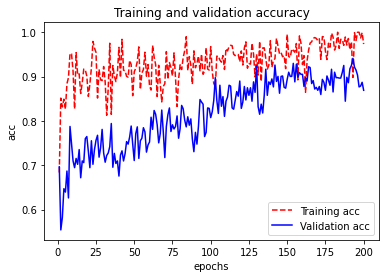

<Figure size 432x288 with 0 Axes>

In [18]:
acc = train_auc
val_acc = val_auc

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

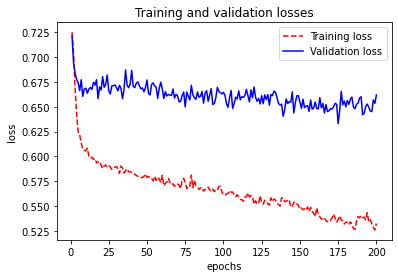

<Figure size 432x288 with 0 Axes>

In [19]:
acc = train_losses
val_acc = test_losses

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training loss'  )
plt.plot ( epochs, val_acc,  'b', label='Validation loss')
plt.title ('Training and validation losses')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

In [20]:
accuracy_dataframe = pd.DataFrame({"train_auc":train_auc, "val_auc":val_auc})
accuracy_dataframe.to_csv(dataframes_path + "Pesos resnet50/AccuracyDataframe.csv", index=False)
losses_dataframe = pd.DataFrame({"train_auc":train_losses, "val_auc":test_losses})
losses_dataframe.to_csv(dataframes_path +"Pesos resnet50/LossesDataFrame.csv", index=False)

In [21]:
accuracy_dataframe.sort_values(by=['val_auc'], ascending=False)

,train_auc,val_auc
192,0.898117,0.941176
153,0.958944,0.929791
155,0.974585,0.927894
141,0.940371,0.925996
191,0.978431,0.925047
...,...,...
3,0.849020,0.647059
4,0.826389,0.639469
6,0.897537,0.626186
2,0.831527,0.582543


In [17]:
# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 32

In [69]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load(dataframes_path + 'Pesos resnet50/resnet50_weights_185.pt')
#checkpoint = torch.load(dataframes_path + 'Pesos Vgg16/vgg16_weights_75.pt',map_location ='cpu')

model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ("cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    #print(pred)
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [70]:
submission = pd.DataFrame({"image_name":fn_list, "target":pred_list})
submission.to_csv(dataframes_path + "Pesos resnet50/Submission.csv", index=False)

In [71]:
df_test = pd.read_csv(dataframes_path + "test.csv")
df_merge = pd.merge(df_test, submission, left_index=True, right_index=True)

print("------------Matriz de confusión-------------------")
print(confusion_matrix(df_merge['target_x'], df_merge['target_y']))

print("------------Exactitud-------------------")
print(accuracy_score(df_merge['target_x'], df_merge['target_y']))

print("------------Precision-------------------")
print(precision_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(precision_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------Sensibilidad-------------------")
print(recall_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(recall_score(df_merge['target_x'], df_merge['target_y'], average=None))

print("------------F1 score-------------------")
print(f1_score(df_merge['target_x'], df_merge['target_y'], average='weighted'))
print(f1_score(df_merge['target_x'], df_merge['target_y'], average=None))

------------Matriz de confusión-------------------
[[221  57]
 [ 79 184]]
------------Exactitud-------------------
0.7486136783733827
------------Precision-------------------
0.7497042769524189
[0.73666667 0.76348548]
------------Sensibilidad-------------------
0.7486136783733827
[0.79496403 0.69961977]
------------F1 score-------------------
0.7479112408980845
[0.76470588 0.73015873]
